In [ ]:
#Installing all appropriate packages
!pip install transformers datasets torch pandas scikit-learn matplotlib seaborn requests planet-terp-client

In [ ]:
#Imports
import pandas as pd
import numpy as np
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Testing API
from planet_terp import PlanetTerp

client = PlanetTerp()

professors = ["Kendall Williams", "Justin Wyss-Gallifent", "Larry Herman", "Fawzi Emad", "Nelson Padua-Perez"]


3.3481
4.6025
3.1399
3.7035
4.2241


In [ ]:
#Gathering all reviews and organizing in array
#gets all reviews
from planet_terp import PlanetTerp

client = PlanetTerp()
professors = [
    "Kendall Williams",
    "Justin Wyss-Gallifent",
    "Nelson Padua-Perez",
    "Pedram Sadeghian",
    "Fawzi Emad"
]

all_reviews = []

for name in professors:
    try:
        p = client.professor(name, reviews=True)
        reviews = p.reviews
        for r in reviews: #for every review in this professors reviews, append it to the array
            all_reviews.append({
              "professor": name,
              "review_text": r.review,
              "rating": r.rating,
              "course": r.course,
        })
    except Exception as e:
        print(f"Failed to fetch {name}: {e}")


In [ ]:
#Cleaning up the data and storing in pandas dataframe
df = pd.DataFrame(all_reviews)
df = df.dropna()
df = df[df["review_text"].str.strip() != ""]
df["label"] = df["rating"] - 1  #replacing with 0-4 labels
df["review_text"] = df["review_text"].str.replace("\n", " ").str.strip()

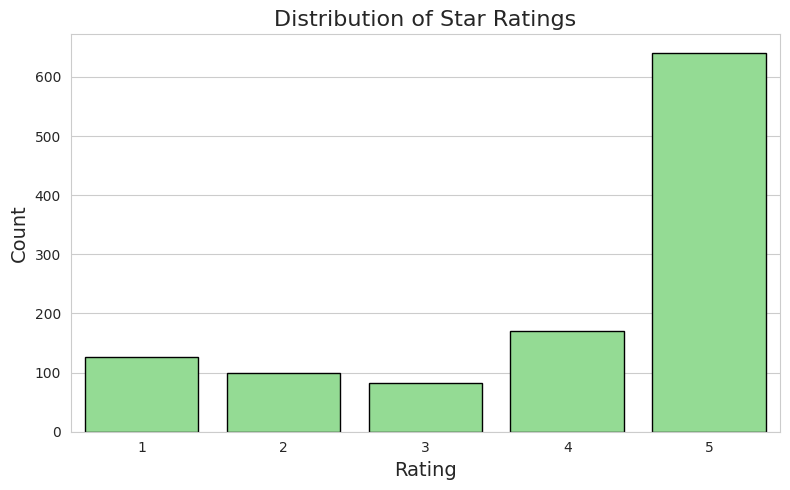

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  #larger, cleaner figure
sns.set_style("whitegrid")  #clean background

sns.countplot(
    x=df["rating"],
    color="#88E788",  #bar color
    edgecolor="black" #makes bars more defined
)

plt.title("Distribution of Star Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
#Setting up training
from sklearn.model_selection import train_test_split
#Splits between training data frame and validation dataframe
#test size is 2, testing on the label column
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

MAX_LEN = 256
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class ReviewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["review_text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = ReviewsDataset(train_df, tokenizer, MAX_LEN)
val_dataset = ReviewsDataset(val_df, tokenizer, MAX_LEN)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#TRAIN

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score


#load model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=5
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    report_to=[]
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2201277270.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


{'eval_loss': 0.9306154251098633,
 'eval_accuracy': 0.6607142857142857,
 'eval_f1_macro': 0.3272320523167981,
 'eval_runtime': 1.7462,
 'eval_samples_per_second': 128.279,
 'eval_steps_per_second': 4.009,
 'epoch': 3.0}

In [ ]:
#Inferencing. Here the model is given new unseen reviews and asking it to predict a star rating
#Here, we will pass in two simple reviews the model has not seen. 1st: Clyde Kruskal 2nd: Michael Marsh

new_reviews = [
    "SUCH A GOOD TEACHER!! Always has a joyful attitude and is great at going over every detail. 10/10!!",
    "Class wastes time. Projects terrible",
    "Yoon is nice person, but should not be teaching this class especially. Projects are easy but exams are unfair and completely unrelated to any other work we do in the class. Most multiple choice questions are on random niche things that he talked about for 30 seconds and have one bullet point on a random lecture slide. He tests on things beyond the scope of 131, such as sorting algorithms. He also gets into convoluted explanations of topics that do not help with understanding the topic add hand. Avoid yoon if possible, especially for 131. If you have him be sure to go over all the lecture slides before exams/quizzes and do your own research on things that are not fully explained in the slides.",
    "To sum things up concisely, the topics covered in this class aren't bad, but Cliff's lecturing style hurts overall engagement. I could not attend an entire lecture without sleeping or doing other work. Most of my productive learning came from reading Anwar's slides and Cliff's notes and starting the projects early. Exams, on the other hand, were pretty chill. They were very similar to past semester exams posted on the website. The quizzes were meh. As many others have mentioned, the first quiz is generally the worst. After we took the first quiz, my TA said, Congrats, guys. The first quiz historically has a D average. Don't panic about the first one; the others are much better. Overall, three stars for many opportunities to help your grade/do well. Minus two stars for Cliff's lecture engagement."]

inputs = tokenizer(new_reviews, padding=True, truncation=True, return_tensors="pt").to(device)

#Predicts the grades
model.eval()
with torch.no_grad(): #picks class with the highest score
    outputs = model(**inputs) #outputs.logits: the model's rae scores for the 5 rating classes
    predictions = torch.argmax(outputs.logits, dim=-1)

print("Predicted labels:", predictions.cpu().numpy())
#The model predicts 0 and 4 (5 == 4 and 0 == 1 since we are using the label column)

Predicted labels: [4 0 0 4]


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

#make sure the model is in evaluation mode
model.eval()

preds = []
labels = []
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=-1)

        preds.extend(batch_preds.cpu().numpy())
        labels.extend(label.cpu().numpy())

#convert to numpy arrays for easier handling
preds = np.array(preds)
labels = np.array(labels)

#print predictions vs actual labels for the first 20 samples
for i in range(min(20, len(preds))):
    print(f"Review: {val_df.iloc[i]['review_text']}")
    print(f"Actual rating: {val_df.iloc[i]['rating']}, Predicted label: {preds[i] + 1}")  # +1 if you mapped ratings 1-5 → 0-4
    print("-" * 80)


Review: Took justin for 130 and 131 he is the best math teacher I have ever had, not only is he a really awesome teacher, he is soooo chill. the environment in class is fun and loose and he actually cares about his students! Take justin if u can he is the man!
Actual rating: 5, Predicted label: 5
--------------------------------------------------------------------------------
Review: Dr. Williams is a very great professor. I personally love his teaching style. He goes into detail about the steps involved in solving a problem which I thought was very helpful and he loves when people ask questions. He teaches right out of the textbook so the suggested problems are really helpful when studying for the exams. Oftentimes the questions are also pulled right out of the textbook. His exams were super fair and were really helpful for the finals. Overall Dr. William is a great professor and I would totally recommend taking him for 140.
Actual rating: 5, Predicted label: 5
-----------------------

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.50      0.76      0.60        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        17
           4       0.28      0.15      0.19        34
           5       0.74      0.97      0.84       128

    accuracy                           0.66       224
   macro avg       0.30      0.38      0.33       224
weighted avg       0.52      0.66      0.58       224

MAE: 0.5758928571428571


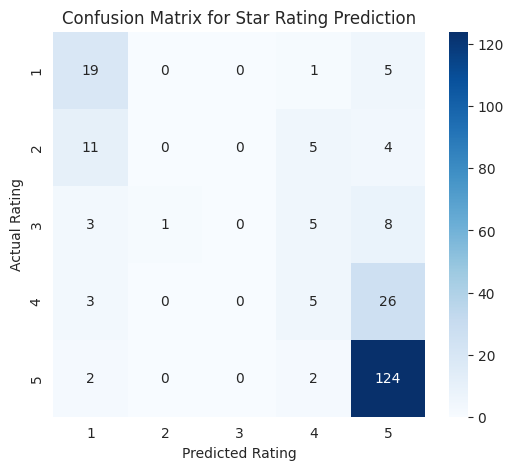

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

labels_orig = labels + 1
preds_orig = preds + 1

print(classification_report(labels_orig, preds_orig))
print("MAE:", mean_absolute_error(labels_orig, preds_orig))

#compute confusion matrix
cm = confusion_matrix(labels_orig, preds_orig)
classes = [1, 2, 3, 4, 5]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix for Star Rating Prediction")
plt.show()
